In [134]:
%reload_ext autoreload
%autoreload 2

import ast
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import helpers


sns.set_theme()

In [135]:
movies, characters = helpers.import_movies_data("./data/")
# NOTE: drop entry if either side is missing 
# NOTE: a movie has multiple actors and thus multiple rows
df_by_actors = pd.merge(movies, characters, how='inner', on=['wikipedia_movie_ID'])

print(df_by_actors.shape)

/Users/chuck/IdeaProjects/ada-2023-project-zalix/helpers.py:73: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  movies["year_released"] = pd.to_datetime(


(106354, 25)


In [136]:
# NOTE: keep data till 2009 (2010 - 2013 dropped: incomplete decade)
df_by_actors = df_by_actors[df_by_actors['year_released'] <= 2009]

# add decade column
df_by_actors['decade'] = df_by_actors['year_released'].apply(lambda x: int(x/10)*10)

# rename rating column
df_by_actors = df_by_actors.rename(columns={'averageRating': 'imdb_rating'})

In [137]:
# create a data frame of unique films 
df_by_films = df_by_actors.drop_duplicates(subset=['wikipedia_movie_ID']).reset_index().set_index('wikipedia_movie_ID').copy()

In [138]:
# compute # cast ethnicities per film
# NOTE: ignore missing values in ethnicity columns 
# NOTE: fill NaN with 1 after tallying 
n_ethnicities_per_film = df_by_actors.groupby(['wikipedia_movie_ID'])['actor_ethnicity'].nunique().replace(0, 1)

# add # cast ethnicities column
df_by_films['num_ethnicities'] = n_ethnicities_per_film

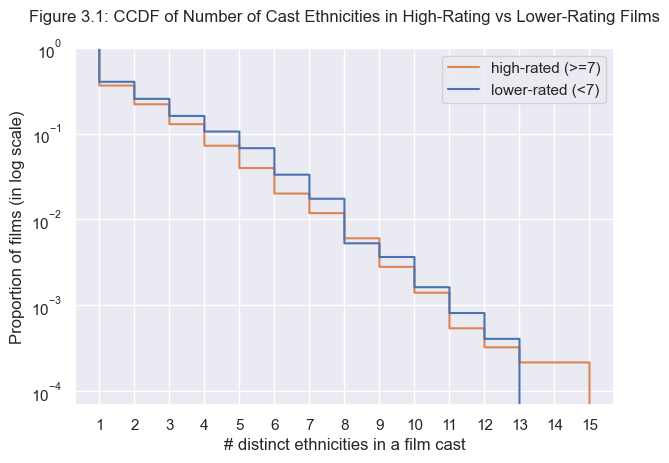

In [139]:
# 1. distribution of # cast ethnicities among good vs non-good films => show ethnic diversity as a potentially interesting factor in film rating


# plot CDF of # cast ethnicities ~ proportion between good vs non-good films
df_by_films['good'] = df_by_films['imdb_rating'] >= 7.0
# NOTE: close curves but good films curve almost always above (greater proportion > x) non-good => good films have greater ethnic diversity in cast in general 
ax = sns.ecdfplot(data=df_by_films, x="num_ethnicities", hue="good", hue_order=[1, 0], complementary=True, log_scale=[False, True])
ax.set_xlabel('# distinct ethnicities in a film cast')
ax.set_ylabel('Proportion of films (in log scale)')
ax.set_title('Figure 3.1: CCDF of Number of Cast Ethnicities in High-Rating vs Lower-Rating Films', y=1.05)
ax.legend(['high-rated (>=7)', 'lower-rated (<7)'])
# x-axis displays all values
xticks = np.arange(1, df_by_films['num_ethnicities'].max() + 1)
plt.xticks(xticks)

plt.tight_layout()

<!-- exploratory analysis: ethnic diversity as an interesting factor to set the stage 
    - [x] expect good films to have a higher proportion of films with greater ethnic diversity among cast -->

Hollywood, and many major film studios around the world, have long faced criticism for the lack of racial diversity in its workforce both on and off the screens. In recent decades, there has also been a growing call for greater representation of racial minorities on the silver screen. [Figure X] shows a quick exploratory analysis of the distribution of the number of ethnicities among cast members of each film between 1900 to 2009. As shown in the figure, the curve representing films rated 7 or above is consistently higher than that of films rated below. This suggests that highly rated films generally have more ethnically diverse casts than those lower rated. 

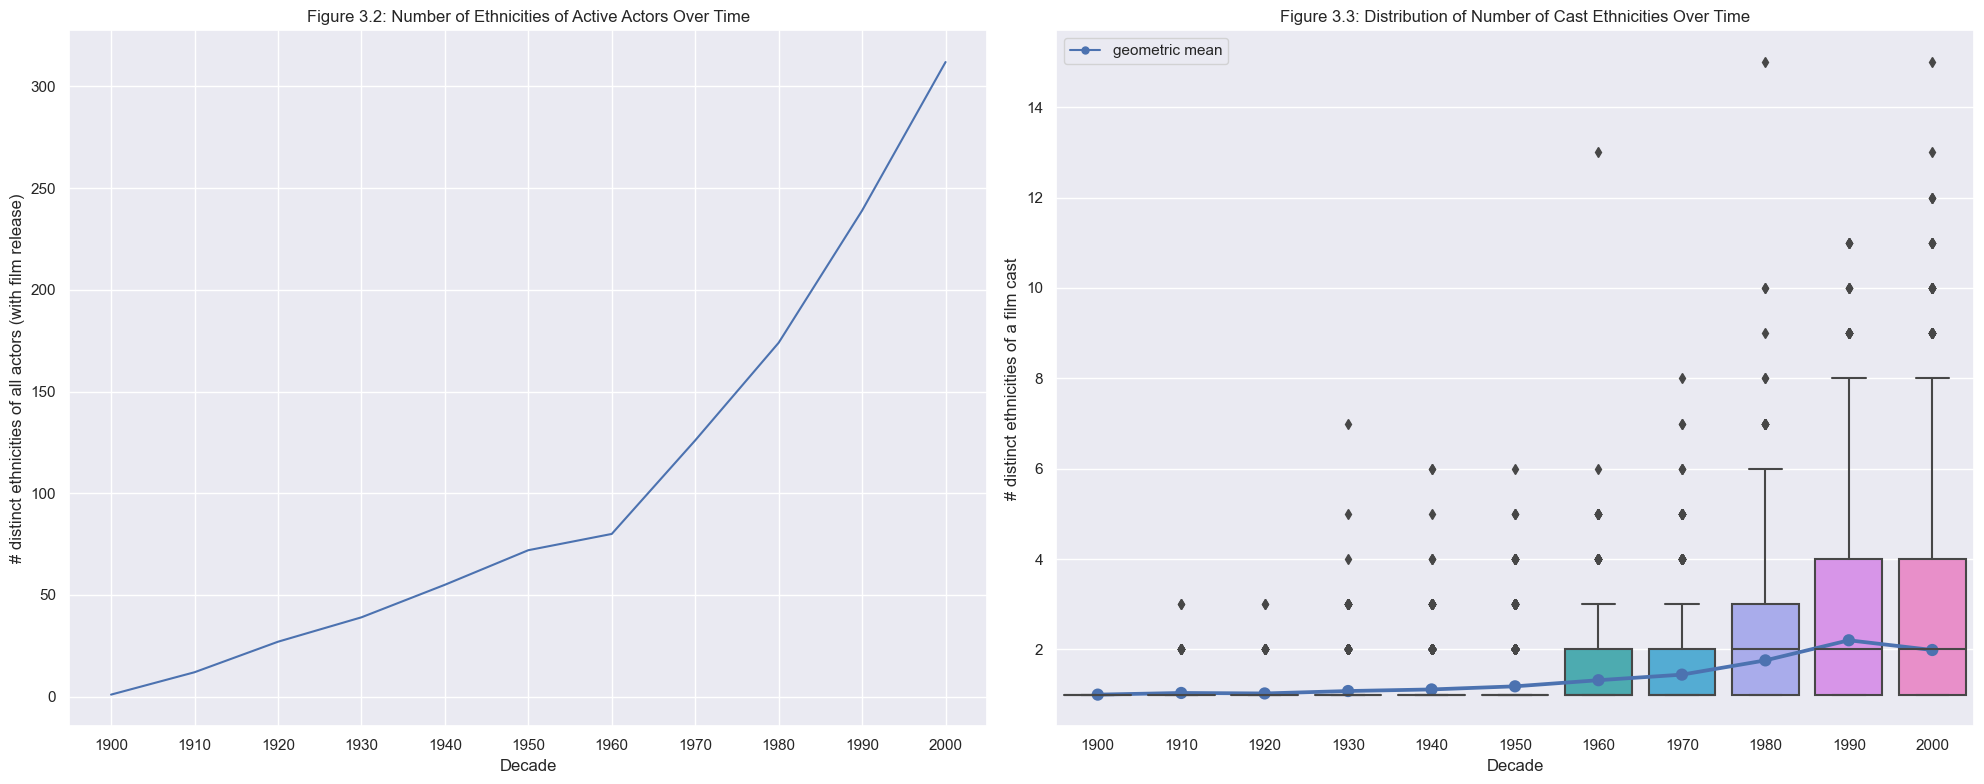

In [140]:
# 2. ethnic demographic change among actors (# actor ethnicities) over time AND ethnic diversity change among cast/on-screen (# cast ethnicities) over time 

# compute # distinct ethnicities among actors for each decade
# NOTE: ignore missing values in ethnicity column
n_actor_ethnicities_by_decade = pd.crosstab(df_by_actors['decade'], df_by_actors['actor_ethnicity']).apply(lambda x: (x != 0).sum(), axis=1)

decades = np.sort(df_by_films['decade'].unique())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# plot decade ~ # distinct actor ethnicities across all films
sns.lineplot(n_actor_ethnicities_by_decade, ax=ax1)
# Add title for the plot
ax1.set_title('Figure 3.2: Number of Ethnicities of Active Actors Over Time')
ax1.set_xlabel('Decade')
ax1.set_ylabel('# distinct ethnicities of all actors (with film release)')
ax1.set_xticks(decades)

# plot decade ~ (distribution) # actor ethnicities per film + geometric mean
# NOTE: # ethnicities among cast follows power law distribution => use robust statistics
sns.boxplot(df_by_films, x='decade', y='num_ethnicities', ax=ax2)
sns.pointplot(df_by_films, x='decade', y='num_ethnicities', estimator=stats.gmean, errorbar=None, ax=ax2)
ax2.set_ylabel('# distinct ethnicities of a film cast')
ax2.set_xlabel('Decade')
ax2.set_title('Figure 3.3: Distribution of Number of Cast Ethnicities Over Time')

from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='b', label='geometric mean', markerfacecolor='b', markersize=5)]
ax2.legend(handles=legend_elements)

plt.tight_layout()

<!-- ethnic demographic change among actors (# actor ethnicities) over time AND ethnic diversity change among cast/on-screen (# cast ethnicities) over time 
    - [x] expect upward trends in both => shift in actor ethnic demographics reflected by greater ethnic representation on screen -->

To set the stage, let's first take a look at how the ethnic demographic of actors has evolved globally over time. [Figure X] shows that the 110-year history of film-making has witnessed a booming growth in the ethnic background of actors, with the trend accelarating after 1960s. 

This fast diversifying shift in the acting workforce is reflected on the silver screen, through greater, though much more subdued, ethnic representation by the collective featuring of actors from different ethnic background in the same films. 

In [Figure X], for the first half of the century, nearly all films' casts have remained dominated by a single ethnicity, as both the average and the spread remained thin. [Figure X] above reveals that the number of cast ethnicities follows power law distribution. [Figure X] therefore measures its average across films in each decade by its geometric mean. 

Since 1960s, however, the average cast ethnicity has slowly climbed, reaching 2 for the first time in 1900s and revearsing its trend slightly at the turn of the century. In the backdrop of a widening spread, more and more films have joined to cast more actors from different ethnic groups during this period, with half of the films featuring actors from at least 2 ethnic groups and a quater of films featuring more than 3 since 1980s. 

Although most films' casts have stayed ethnically homogeneous, there has always been some outlier films throughout history with much more ethnically diverse cast, potentially paving the way for further diversification in the future.

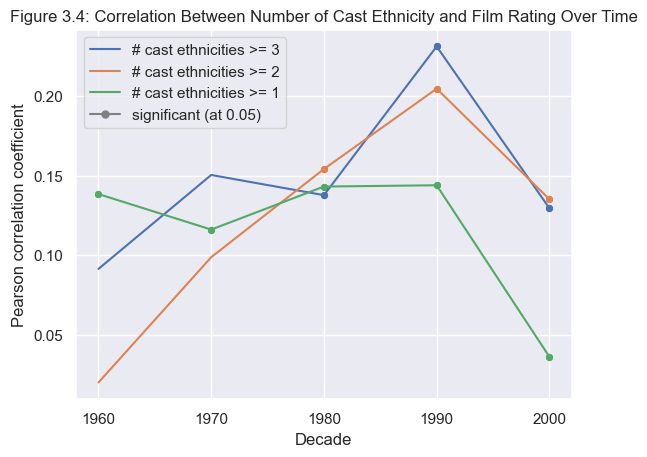

In [141]:
# 3. correlation between cast’s ethnic diversity and film rating over time 

# NOTE: begin from 1960s (before almost all films num_ethnicities = 1)
df_by_films = df_by_films[df_by_films['decade'] >= 1960].copy()

# compute the correlation coefficient of # cast ethnicities and film rating for each decade

fig, ax = plt.subplots()
# plot decade ~ # cast ethnicities and film rating correlation coefficient
for n in range(3, 0, -1):
  cor_by_decade = df_by_films[df_by_films['num_ethnicities'] >= n].groupby('decade').apply(lambda x: stats.pearsonr(x['num_ethnicities'], x['imdb_rating']))
  coef = cor_by_decade.apply(lambda x: x[0])
  p_val = cor_by_decade.apply(lambda x: x[1])

  axis = sns.lineplot(coef, ax=ax, label=f'# cast ethnicities >= {n}')
  # mark significant coefficients
  line_color = axis.get_lines()[-1].get_color()
  sns.scatterplot(coef[p_val <= 0.05], ax=ax, color=line_color)

ax.set_xticks(decades[-5:])
ax.set_xlabel('Decade')
ax.set_ylabel("Pearson correlation coefficient")
ax.set_title("Figure 3.4: Correlation Between Number of Cast Ethnicity and Film Rating Over Time")

marker_legend = Line2D([0], [0], marker='o', color='grey', markerfacecolor='grey', markersize=5, label='significant (at 0.05)')

handles, labels = ax.get_legend_handles_labels()
handles.append(marker_legend)
ax.legend(handles=handles)


<!-- correlation: more ethnically diverse films more well-received/higher rating
    - [ ] ethnic diversity associated/appreciated more? 

- explore cast's ethnic diversity associated with higher rating (vs influence later)
- cut-off from 1960s onwards based on spread in distribution

- generally small but positive correlation throughout
- strongest correlation at num_ethnicities >= 3 tier & 3 ethnicities as minimum threshold for an ethnically diverse cast  -->

History has shown that actors from increasingly diverse ethnic backgrounds are getting film roles and seen on the movie screens. However, are the audience appreciating this? To examine how ethnic diversity impacts a film's overall perceived quality by the audience and also how this impact has changed over time, we analyze the relationship between a film's cast ethnic diversity and its audience ratings. Tieing into the concept of 'representation', the ethnic diversity of a film is measured by the total number of different ethnicities among actors in a film's cast as seen directly by audiences on the movie screen. Film quality as perceived by the audiences is captured by the overall weighted average score of all user ratings on IMDB. As the vast majority of films consist of actors with identical ethnicity until 1950s, 1960s is chosen at the period to begin the analysis. 

In general, there is a small but positive correlation between a film's cast ethnic diversity and rating. As shown in [Figure X] at various levels, across decades, the more ethnically diverse the cast, the higher the film rating. This correlation, measured by the Pearson Correlation Coefficient, is the strongest at the diversity level where only films featuring actors from at least 3 different ethnic groups are considered. We therefore uses this as a threshold to split films into ethnically diverse and non-diverse groups to continue the analysis. This threshold makes sense because in a country with one dominant ethnic group, it makes sense to see at least two minority ethnic group also featured to qualify as 'diverse'.

This begs the question - does an ethnically diverse cast lead to a more highly-rated film? Let's dive in. 

In [142]:
# build regression model for propensity matching on ethnic diversity


# feature selection
# use observed covariates: movie_release_date, movie_languages, movie_countries, movie_genres
df_by_films['ethnic_diverse'] = df_by_films['num_ethnicities'] >= 3

df_reg = df_by_films[['movie_release_date', 'movie_languages', 'movie_countries', 'movie_genres', 'ethnic_diverse', 'decade']].copy()

# data preprocessing
# handle missing values: drop rows
df_reg = df_reg.replace('{}', np.nan)

print(df_reg.isna().sum(axis=0) / df_reg.shape[0])

old_shape = df_reg.shape
df_reg = df_reg.dropna()
# NOTE: dropped 7.5% rows
print(old_shape, df_reg.shape, df_reg.shape[0] / old_shape[0])


movie_release_date    0.000000
movie_languages       0.051084
movie_countries       0.025610
movie_genres          0.007724
ethnic_diverse        0.000000
decade                0.000000
dtype: float64
(7380, 6) (6872, 6) 0.9311653116531166


In [143]:
# feature encoding
# split movie_release_date to year, month, day & standardize
release = pd.to_datetime(df_reg['movie_release_date'])
release_date = pd.DataFrame({'year': release.dt.year, 'month': release.dt.month, 'day': release.dt.day})
release_date_std = StandardScaler().fit_transform(release_date)

# extract movie_languages values & one-hot encode
languages = df_reg['movie_languages'].apply(lambda x: list(ast.literal_eval(x).values()))
languages_encoded = languages.str.join('|').str.get_dummies()

# extract movie_countries values & one-hot encode
countries = df_reg['movie_countries'].apply(lambda x: list(ast.literal_eval(x).values()))
countries_encoded = countries.str.join('|').str.get_dummies()

# extract movie_genres values & one-hot encode
genres = df_reg['movie_genres'].apply(lambda x: list(ast.literal_eval(x).values()))
genres_encoded = genres.str.join('|').str.get_dummies()


In [144]:
# model fitting 
# predict each film's probability of being ethnically diverse 
X = np.concatenate((release_date_std, languages_encoded, countries_encoded, genres_encoded), axis=1)
Y = df_reg['ethnic_diverse']
# NOTE: unbalanced dataset => class_weight=balanced
prob = LogisticRegression(random_state=12, solver='lbfgs', max_iter=1000, class_weight='balanced').fit(X, Y).predict_proba(X)[:, 1]

In [145]:
# propensity matching 

def find_matching(treated, control):
  G = nx.Graph()
  # add edges between treated and control
  for ti, t in treated.iterrows():
    for ci, c in control.iterrows():
      # match on similarity of propensity
      similarity = np.abs(t["propensity"] - c["propensity"])
      G.add_weighted_edges_from([(ti, ci, similarity)])
  # find optimal matching approximation (performance)
  return nx.approximation.min_maximal_matching(G)

def find_matching_for_decade(x):
  start = time.time()
  matching = find_matching(x[x['ethnic_diverse']], x[~x['ethnic_diverse']])
  end = time.time()
  print(f'decade: {x["decade"].iloc[0]}, time: {end - start}s')
  return matching

df_reg['propensity'] = prob
# match by each decade separately (performance)
matching_by_decade = df_reg.groupby('decade').apply(lambda x: find_matching_for_decade(x))

decade: 1960, time: 0.9661409854888916s
decade: 1970, time: 1.342017650604248s
decade: 1980, time: 4.582782030105591s
decade: 1990, time: 9.472424983978271s
decade: 2000, time: 29.857988834381104s


In [146]:
# get indices of matched films
matches = np.array([list(pair) for matching in matching_by_decade.values for pair in matching]).flatten()

print([len(matching) for matching in matching_by_decade.values])
print(len(matches))

[98, 143, 369, 747, 1150]
5014


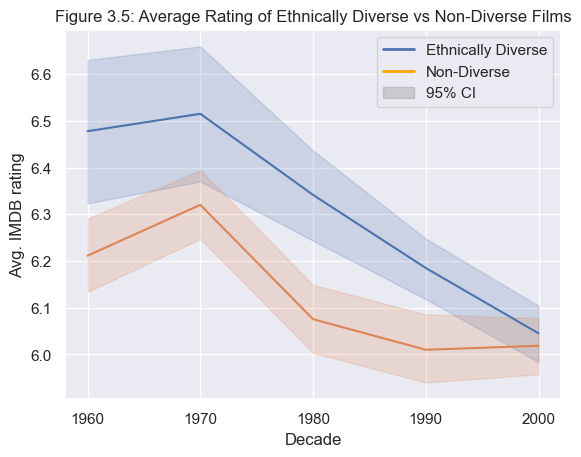

In [147]:
# 4. average rating of ethnically diverse films vs ethnically non-diverse films 

from matplotlib.patches import Patch

fig, ax1 = plt.subplots()

# plot decade ~ avg rating of ethnically diverse films (treated) vs ethnically non-diverse films (control)
sns.lineplot(df_by_films, x='decade', y='imdb_rating', hue='ethnic_diverse', errorbar='ci', hue_order=[True, False], ax=ax1)

ax1.set_title('Figure 3.5: Average Rating of Ethnically Diverse vs Non-Diverse Films')
ax1.set_xticks(decades[-5:])
ax1.set_xlabel('Decade')
ax1.set_ylabel('Avg. IMDB rating')

legend_elements = [Line2D([0], [0], color='b', lw=2, label='Ethnically Diverse'),
                   Line2D([0], [0], color='orange', lw=2, label='Non-Diverse'),
                   Patch(facecolor='grey', edgecolor='grey', label='95% CI', alpha=0.3)]
ax1.legend(handles=legend_elements)

[ 196  286  738 1494 2300]
decade
1960    0.005515
1970    0.252873
1980    0.000076
1990    0.002504
2000    0.581842
dtype: float64
Index([1960, 1980, 1990], dtype='int64', name='decade')


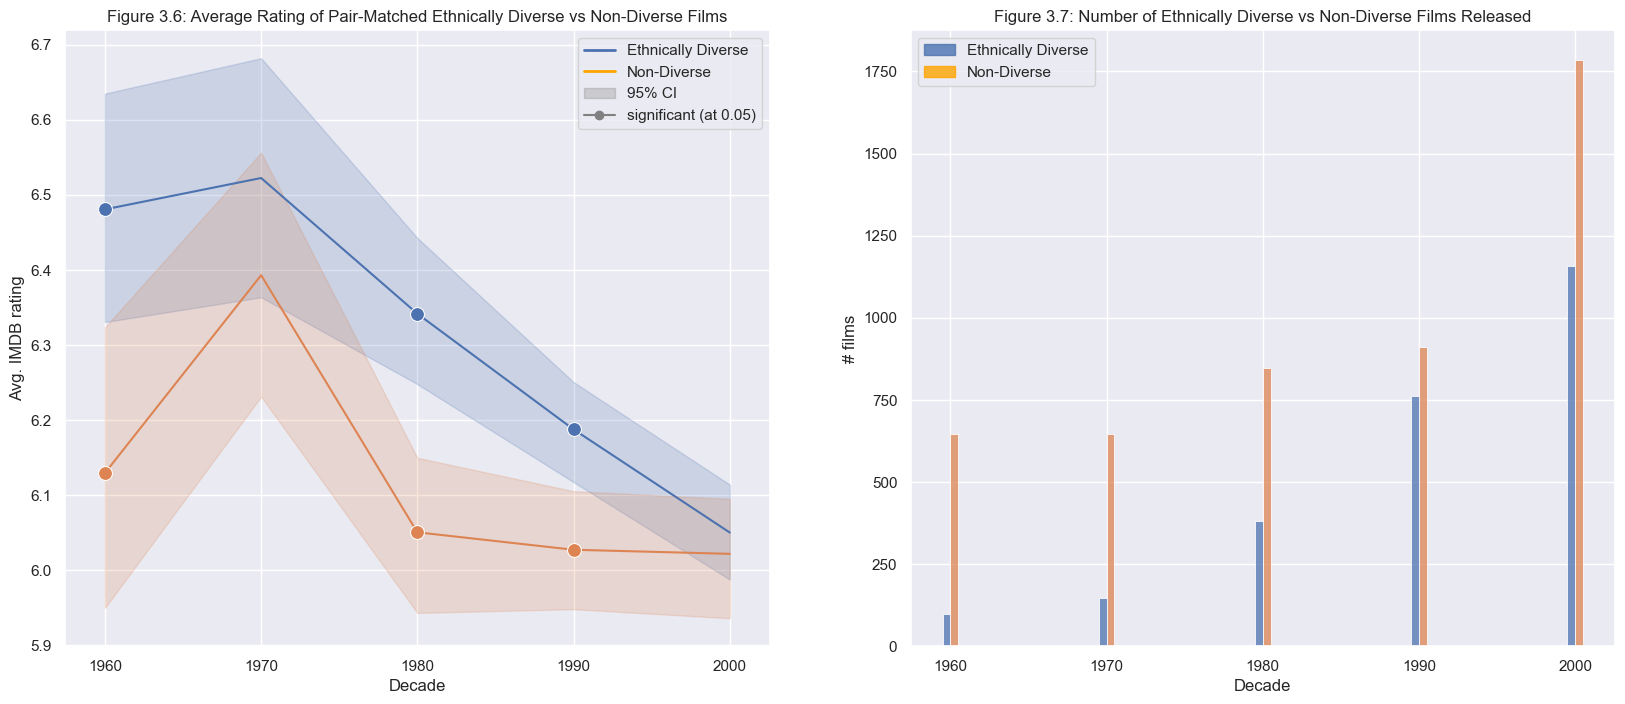

In [148]:
# 5. significance in difference in average ratings between treated and control after pair matching for each decade

fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(20, 8), sharex=True)

# compute significance in difference in average ratings
df_matches = df_by_films.loc[matches]
p_values = df_matches.groupby('decade').apply(lambda x: stats.ttest_ind(x[x['ethnic_diverse']]['imdb_rating'], x[~x['ethnic_diverse']]['imdb_rating'], alternative='two-sided')[-1])
sig_decades = p_values[p_values < 0.05].index

print(df_matches.groupby('decade').size().values)
print(p_values)
print(sig_decades)

# plot decade ~ avg ratings of pair-matched ethnically diverse films (treated) vs non-ethnically diverse films (control) + significance markers 
sns.lineplot(df_matches, x='decade', y='imdb_rating', hue='ethnic_diverse', errorbar='ci', hue_order=[True, False], ax=ax2)
# add markers for statistically significant decades
sns.lineplot(df_matches[df_matches['decade'].isin(sig_decades)], x='decade', y='imdb_rating', hue='ethnic_diverse', hue_order=[True, False], errorbar=None, legend=False, ax=ax2, marker='o', linestyle='none', markersize=10)

# plot decade ~ # ethnically diverse films vs ethnically non-diverse films
sns.histplot(df_by_films, x='decade', hue='ethnic_diverse', hue_order=[True, False], discrete=True, multiple='dodge', ax=ax3)


ax2.set_title('Figure 3.6: Average Rating of Pair-Matched Ethnically Diverse vs Non-Diverse Films')
ax3.set_title('Figure 3.7: Number of Ethnically Diverse vs Non-Diverse Films Released')

ax2.set_xlabel('Decade')
ax3.set_xlabel('Decade')

ax2.set_ylabel('Avg. IMDB rating')
ax3.set_ylabel('# films')

marker_legend = Line2D([0], [0], marker='o', color='grey', markerfacecolor='grey', markersize=6, label='significant (at 0.05)')
legend_elements.append(marker_legend)
ax2.legend(handles=legend_elements)

legend_elements = [Patch(facecolor='b', edgecolor='b', label='Ethnically Diverse', alpha=0.8), Patch(facecolor='orange', edgecolor='orange', label='Non-Diverse', alpha=0.8)]
ax3.legend(handles=legend_elements)

<!-- correlation: more ethnically diverse films more well-received/higher rating

    - [ ] ethnic diversity associated/appreciated more/higher correlation in recent decades? 
    - [ ] raise question: ethnically diverse cast contributes to higher rating? 

causation & significance: greater ethnic diversity in cast influence/leads to higher rating
    - [ ] expect yes in recent decades where greater ethnic representation translates to higher rating/audience appreciation 


- ethnically diverse films average rating consistently higher, with overlapping ci in 1970s and 2000s
- after pair matching, still the case: 3 statiscally significant difference in means out of 5 decades => presence of influence/causality

- however, average rating of both groups face downward trend, but ethnically diverse films rating decreases more 
- more ethnically diverse films and more ethnically non-diverse films released over the decades alike 
- => potentially because in the earlier decades, few ethnically diverse films and they are generally highly rated, then more studios started producing more films featuring diverse casts and the average rating begin to converge to overall average rating/population mean -->

After establishing treatment group of ethnically diverse films and control group of ethnically non-diverse films, their average ratings are compared in Figure X.1. Notably, films with ethnically diverse cast are rated consistently higher, with only 95% confidence interval overlapping in 1970s and 2000s. After removing covariates such as release date, countries, languages and genres through propensity matching, the same still holds as ethnically diverse films consistently outperform non-diverse films in average rating in every decade. Hypothesis testing reveals that the differences in average ratings are statiscally significant in 3 of 5 decades highlighted in circles in Figure X.2. This confirms that films with ethnically diverse cast tend to be better-received by the audience and contribute to higher ratings. 

However, there exists an obvious downward trend for both groups, with the average rating of ethnically diverse films decreasing faster. This does not necessarily mean that audience appreciates ethnic diversity less over time. As evidenced by Figure X.3, there is a fast-paced growth in the number of ethnically diverse films released over the decades. The decline in rating of ethnically diverse films coincide with this growth. As this number approaches and even surpasses in the last 2 decades the number for ethnically non-diverse films in the previous decades, the average rating of ethnically diverse films also closes in on that of non-diverse ones. This could potentially be because in the earlier decades, few ethnically diverse films are made and they are generally rated quite well. This possibly motivated movie studios to produce more films featuring diverse casts and with increasing volume, the average rating begin to converge to overall average rating representative of the true population mean. This would mean despite recent laudable calls in the public for greater ethnic diversity on the film set, history has shown that ethnic diversity alone does not translate to higher rating.